In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import torch
import transformers
from transformers import BertForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

transformers.__version__
torch.__version__

'1.13.0+cpu'

In [2]:
train = pd.read_csv("/kaggle/input/voc-processed-data/train-nl.tsv", sep="\t")
len(train)

359695

In [3]:
train.head()

,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# language = nl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# document_path = ../data/annotated_data/A/NL-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,heste,O,O,O,O,O,O,_
4,afschrift,O,O,O,O,O,O,_


In [4]:
train['NE-MAIN'].value_counts()

O                                  321262
I-Person                            15444
B-Person                             8216
I-Place                              3766
B-Place                              2856
I-Organization                       2155
B-Organization                        741
I-Organization,B-Place                208
I-Organization,I-Place                111
I-Person,B-Place                      105
I-Person,I-Place                       54
B-Organization,I-Place                 25
B-Person,I-Place                       19
I-Organization,I-Person                 4
B-Organization,B-Place                  2
B-Person,B-Place                        2
B-Organization,I-Person                 1
I-Organization,I-Person,B-Place         1
I-Organization,I-Person,I-Place         1
Name: NE-MAIN, dtype: int64

In [6]:
df = train
df['DOC PATH'] = df['TOKEN'].str.extract(r'# document_path = (.*)', expand=False).ffill()

In [7]:
# Move Sentence # to the front
sentence_col = df.pop('DOC PATH')
df.insert(0, 'DOC PATH', sentence_col)

df = df.dropna()
print(df.isnull().sum())
# df = df.dropna(subset=["NE-MAIN"])
# df = df.dropna(subset=["TOKEN"])

df.head()

DOC PATH               0
TOKEN                  0
NE-MAIN                0
NE-PER-NAME            0
NE-PER-GENDER          0
NE-PER-LEGAL-STATUS    0
NE-PER-ROLE            0
NE-ORG-BENEFICIARY     0
MISC                   0
dtype: int64


,DOC PATH,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
3,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,heste,O,O,O,O,O,O,_
4,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,afschrift,O,O,O,O,O,O,_
5,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,m,O,O,O,O,O,O,_
6,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,In,O,O,O,O,O,O,_
7,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,den,O,O,O,O,O,O,_


In [ ]:
# df[(df != 'O').all(axis=1)]

In [ ]:
# df[(df.iloc[:, :-3] != 'O').all(axis=1)]

In [8]:
# class SentenceGetter(object):
# # https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
#     def __init__(self, df):
#         self.n_sent = 1
#         self.df = df
#         self.empty = False
#         agg_func = lambda s: [(t,a,n,g,l,r,b,m) for t,a,n,g,l,r,b,m in zip(s["TOKEN"].values.tolist(),
#                                                     s["NE-MAIN"].values.tolist(),
#                                                     s["NE-PER-NAME"].values.tolist(),
#                                                     s["NE-PER-GENDER"].values.tolist(),
#                                                     s["NE-PER-LEGAL-STATUS"].values.tolist(),
#                                                     s["NE-PER-ROLE"].values.tolist(),
#                                                     s["NE-ORG-BENEFICIARY"].values.tolist(),
#                                                     s["MISC"].values.tolist())]
#         self.grouped = self.df.groupby("DOC PATH").apply(agg_func)
#         self.sentences = [s for s in self.grouped]

#     def get_next(self):
#         try:
#             s = self.grouped["Sentence: {}".format(self.n_sent)]
#             self.n_sent += 1
#             return s
#         except:
#             return None


class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["TOKEN"].values.tolist(),
                                                           s["NE-MAIN"].values.tolist())]
        self.grouped = self.data.groupby("DOC PATH").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(df)

In [10]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['11',
 '„',
 '„',
 '35',
 'in',
 'beneven',
 'zijn',
 'Gemelde',
 'aanbehumde',
 'vader',
 'de',
 'voorneemde',
 '_',
 '5',
 'tames',
 'va',
 'e2',
 '25',
 '6',
 'welken',
 'hy',
 'testateur',
 'betuigde',
 'in',
 'dienst',
 'aangenemen',
 'en',
 'uitgevaren',
 'te',
 'zyn',
 'ten',
 'Eynde',
 'door',
 'haar',
 'hoog',
 'Edele',
 'groot',
 'agtb=r',
 'uytgekeerd',
 'te',
 'werden',
 'aan',
 'de',
 'geene',
 'da',
 'tot',
 'dies',
 'ontfangst',
 'zal',
 'ef',
 'zullen',
 'Wesen',
 'gequalificeerd',
 'Behuygende',
 'den',
 'toetateur',
 'op',
 'myne',
 'gedane',
 'verage',
 'dat',
 'zyn',
 'beidel',
 'beneden',
 'de',
 'Twee',
 'duivend',
 'rd:s',
 'was',
 'bedragen',
 'de',
 'voorts',
 'heb',
 'ik',
 'Not:s',
 'den',
 'Poetaleur',
 'behoorlyk',
 "g'informeerd",
 'van',
 'de',
 'Jongste',
 'besluyten',
 'door',
 'welmelde',
 'hunne',
 'hoog',
 'Edelhedens',
 'ten',
 'op„',
 'Bigt',
 'van',
 'de',
 'Lijsteygenen',
 'die',
 'gedoopt',
 'in',
 'de',
 'christelyke',
 'leere',
 'onderwesen',

The sentences are annotated with the BIO-schema and the labels look like this.

In [11]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Place', 'I-Place', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-P

In [12]:
tag_values = list(set(df["NE-MAIN"].values))
# tag_values = list(set(df["NE-MAIN"].values) | set(df["NE-PER-NAME"].values) | set(df["NE-PER-GENDER"].values) | set(df["NE-PER-LEGAL-STATUS"].values) | set(df["NE-PER-ROLE"].values) | set(df["NE-ORG-BENEFICIARY"].values) | set(df["MISC"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [13]:
tag2idx

{'I-Organization,B-Place': 0,
 'I-Organization': 1,
 'I-Organization,I-Person,I-Place': 2,
 'I-Place': 3,
 'I-Organization,I-Person': 4,
 'B-Organization,B-Place': 5,
 'B-Organization,I-Place': 6,
 'I-Person,B-Place': 7,
 'I-Person,I-Place': 8,
 'B-Organization,I-Person': 9,
 'I-Organization,I-Person,B-Place': 10,
 'B-Person,B-Place': 11,
 'O': 12,
 'B-Person': 13,
 'B-Place': 14,
 'B-Person,I-Place': 15,
 'I-Person': 16,
 'I-Organization,I-Place': 17,
 'B-Organization': 18,
 'PAD': 19}

In [14]:
def get_tag_distribution(df, tag_col):
    tag_distribution = df.groupby(tag_col).size().reset_index(name='counts')
    tag_distribution = tag_distribution.sort_values('counts', ascending=False)
    tag_distribution['percentage'] = (tag_distribution['counts'] / tag_distribution['counts'].sum()) * 100
    return tag_distribution

In [15]:
columns = ['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']
for col in columns:
    print(f"Tag distribution for {col}:")
    print(get_tag_distribution(df, col))
    print()

Tag distribution for NE-MAIN:
                            NE-MAIN  counts  percentage
18                                O  321259   90.503141
14                         I-Person   15444    4.350790
4                          B-Person    8216    2.314562
17                          I-Place    3766    1.060935
7                           B-Place    2856    0.804575
8                    I-Organization    2155    0.607094
0                    B-Organization     741    0.208750
9            I-Organization,B-Place     208    0.058597
13           I-Organization,I-Place     111    0.031270
15                 I-Person,B-Place     105    0.029580
16                 I-Person,I-Place      54    0.015213
3            B-Organization,I-Place      25    0.007043
6                  B-Person,I-Place      19    0.005353
10          I-Organization,I-Person       4    0.001127
5                  B-Person,B-Place       2    0.000563
1            B-Organization,B-Place       2    0.000563
11  I-Organization

In [16]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(df["NE-MAIN"].unique())))
print(classes)

# tag_values = np.unique(df[['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 
#                            'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']].values)

# # Filter out 'O' and nan values
# classes = list(filter(lambda x: x not in ["O", np.nan], tag_values))
# print(classes)

['B-Person', 'I-Person', 'B-Place', 'I-Place', 'B-Organization', 'I-Organization', 'I-Person,B-Place', 'I-Person,I-Place', 'I-Organization,B-Place', 'I-Organization,I-Place', 'B-Organization,I-Place', 'B-Organization,I-Person', 'I-Organization,I-Person', 'I-Organization,I-Person,B-Place', 'I-Organization,I-Person,I-Place', 'B-Organization,B-Place', 'B-Person,I-Place', 'B-Person,B-Place']


In [17]:
tokenizer = BertTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased', do_lower_case=False) #bert-base-cased

In [18]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [19]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [20]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [21]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [22]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [23]:
label_counts = np.unique(tags, return_counts=True)
print(label_counts) #number 13 occurs 334 times which is a lot (data is imbalanced)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19]), array([   88,   774,     1,  1667,     9,     7,    14,    88,     9,
           1,     2, 98552,  3685,  1295,     2,  7698,    62,   296,
        3800]))


In [24]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [25]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [26]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [27]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [28]:
model = BertForTokenClassification.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [31]:
valid_seq_lens = []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    seq_lens = b_input_mask.sum(dim=1).tolist()
    valid_seq_lens.extend(seq_lens)

In [32]:
def nested_list(lst, seq_lens):
    nested = []
    i = 0
    for seq_len in seq_lens:
        nested.append(lst[i:i+seq_len])
        i += seq_len
    return nested

In [33]:
valid_seq_lens = [int(x) for x in valid_seq_lens]
valid_seq_lens

[72,
 71,
 75,
 72,
 74,
 73,
 74,
 74,
 75,
 74,
 74,
 72,
 73,
 75,
 6,
 75,
 73,
 74,
 75,
 73,
 74,
 72,
 74,
 74,
 74,
 73,
 74,
 75,
 70,
 75,
 68,
 75,
 74,
 72,
 73,
 7,
 74,
 74,
 75,
 75,
 75,
 68,
 75,
 75,
 23,
 68,
 75,
 73,
 71,
 71,
 73,
 73,
 73,
 71,
 75,
 75,
 71,
 75,
 73,
 74,
 74,
 73,
 74,
 75,
 75,
 73,
 72,
 75,
 73,
 74,
 75,
 73,
 75,
 74,
 73,
 74,
 73,
 75,
 74,
 75,
 67,
 72,
 73,
 74,
 71,
 73,
 75,
 75,
 72,
 70,
 73,
 75,
 75,
 72,
 74,
 61,
 9,
 72,
 75,
 73,
 74,
 73,
 73,
 54,
 73,
 73,
 75,
 73,
 72,
 74,
 74,
 73,
 75,
 75,
 74,
 73,
 75,
 64,
 75,
 73,
 73,
 75,
 72,
 74,
 75,
 74,
 73,
 75,
 75,
 72,
 75,
 75,
 75,
 73,
 74,
 75,
 72,
 66,
 73,
 74,
 73,
 75,
 75,
 73,
 75,
 73,
 75,
 74,
 73,
 73,
 74,
 73,
 35,
 75,
 72,
 74,
 75,
 75]

In [34]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD" and l_i >= len(tag_values):
                print("Problematic index:", l_i)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    
    pred_tags_nested = nested_list(pred_tags,valid_seq_lens)
    valid_tags_nested = nested_list(valid_tags,valid_seq_lens)
    print("Validation F1-Score: {}".format(f1_score(pred_tags_nested, valid_tags_nested)))
    print()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.6730013724830416


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  10%|█         | 1/10 [08:29<1:16:26, 509.64s/it]

Validation loss: 0.4163808524608612
Validation Accuracy: 0.893901275266765
Validation F1-Score: 0.12307692307692307

Average train loss: 0.30304792324701946


Epoch:  20%|██        | 2/10 [16:55<1:07:38, 507.36s/it]

Validation loss: 0.28514414727687837
Validation Accuracy: 0.9127266417975188
Validation F1-Score: 0.3072348860257681

Average train loss: 0.21570466740263833


Epoch:  30%|███       | 3/10 [25:24<59:18, 508.38s/it]  

Validation loss: 0.2603766441345215
Validation Accuracy: 0.9253925566062289
Validation F1-Score: 0.3965014577259475

Average train loss: 0.16352482918235992


Epoch:  40%|████      | 4/10 [33:54<50:52, 508.74s/it]

Validation loss: 0.2644786536693573
Validation Accuracy: 0.9285156588878286
Validation F1-Score: 0.4220907297830375

Average train loss: 0.1257856292857064


Epoch:  50%|█████     | 5/10 [42:21<42:20, 508.16s/it]

Validation loss: 0.2597320586442947
Validation Accuracy: 0.9290361759347618
Validation F1-Score: 0.46820276497695856

Average train loss: 0.09876132160425186


Epoch:  60%|██████    | 6/10 [50:49<33:52, 508.08s/it]

Validation loss: 0.28413123190402984
Validation Accuracy: 0.9290361759347618
Validation F1-Score: 0.47738209817131855

Average train loss: 0.08265229703651535


Epoch:  70%|███████   | 7/10 [59:17<25:24, 508.01s/it]

Validation loss: 0.2902996689081192
Validation Accuracy: 0.9322460310575171
Validation F1-Score: 0.5214081826831588

Average train loss: 0.07028138620985878


Epoch:  80%|████████  | 8/10 [1:07:45<16:55, 507.94s/it]

Validation loss: 0.3122988134622574
Validation Accuracy: 0.9305109742344062
Validation F1-Score: 0.5163704396632367

Average train loss: 0.061819550229443444


Epoch:  90%|█████████ | 9/10 [1:16:12<08:27, 507.93s/it]

Validation loss: 0.31305791437625885
Validation Accuracy: 0.9296434458228507
Validation F1-Score: 0.5181159420289855

Average train loss: 0.05840605931977431


Epoch: 100%|██████████| 10/10 [1:24:40<00:00, 508.05s/it]

Validation loss: 0.3156898856163025
Validation Accuracy: 0.9298169515051617
Validation F1-Score: 0.521978021978022



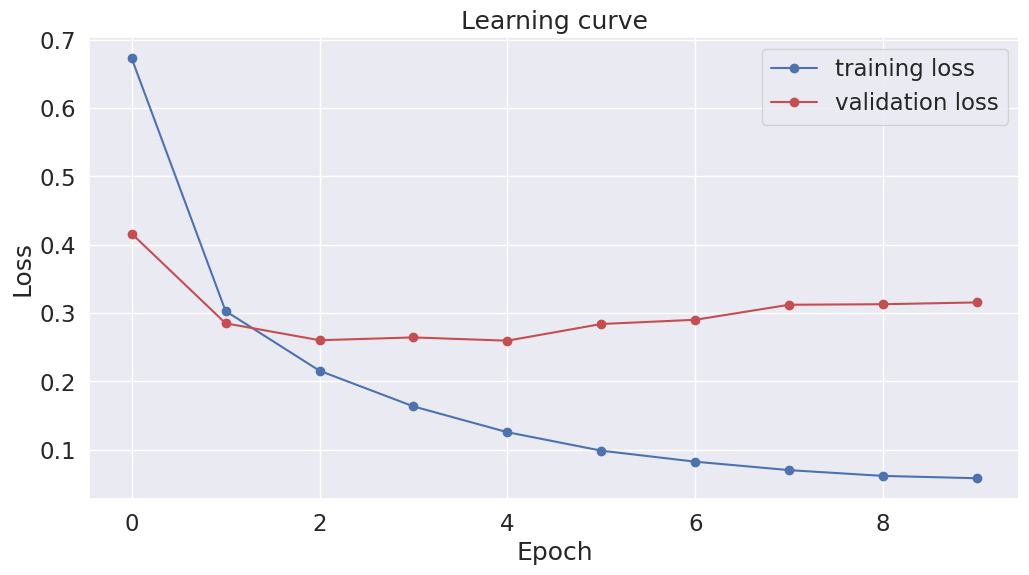

In [35]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()